In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

In [4]:
df = pd.read_csv('data/NASCAR/NASCAR 2017-2024 Full Race  Points Data - Cup.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (11325, 18)
Columns: ['year', 'race_num', 'track', 'track_type', 'fin', 'start', 'car_num', 'driver', 'manu', 'team_name', 'laps', 'laps_led', 'status', 'points', 'stage_1', 'stage_2', 'stage_3_or_duel', 'stage_points']


,year,race_num,track,track_type,fin,start,car_num,driver,manu,team_name,laps,laps_led,status,points,stage_1,stage_2,stage_3_or_duel,stage_points
0,2017,-1,Daytona,superspeedway,1,1,24,Chase Elliott,Chevrolet,Hendrick Motorsports,60,25,running,NaN,NaN,NaN,1.0,10
1,2017,-1,Daytona,superspeedway,2,12,1,Jamie McMurray,Chevrolet,Chip Ganassi Racing,60,0,running,NaN,NaN,NaN,2.0,9
2,2017,-1,Daytona,superspeedway,3,4,4,Kevin Harvick,Ford,Stewart-Haas Racing,60,0,running,NaN,NaN,NaN,3.0,8
3,2017,-1,Daytona,superspeedway,4,2,2,Brad Keselowski,Ford,Team Penske,60,28,running,NaN,NaN,NaN,4.0,7
4,2017,-1,Daytona,superspeedway,5,5,20,Matt Kenseth,Toyota,Joe Gibbs Racing,60,0,running,NaN,NaN,NaN,5.0,6


In [5]:
df.info()
display(df[['driver','year','race_num','track','fin','start','laps_led','status','points','stage_points']].head(10))

# Convert some columns to numeric where possible
df['fin'] = pd.to_numeric(df['fin'], errors='coerce')     # non-numeric -> NaN
df['start'] = pd.to_numeric(df['start'], errors='coerce')
df['laps_led'] = pd.to_numeric(df['laps_led'], errors='coerce')
df['points'] = pd.to_numeric(df['points'], errors='coerce')
df['stage_points'] = pd.to_numeric(df.get('stage_points', pd.Series()), errors='coerce')  # safe-get

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11325 entries, 0 to 11324
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             11325 non-null  int64  
 1   race_num         11325 non-null  int64  
 2   track            11325 non-null  object 
 3   track_type       11325 non-null  object 
 4   fin              11325 non-null  int64  
 5   start            11325 non-null  int64  
 6   car_num          11325 non-null  int64  
 7   driver           11325 non-null  object 
 8   manu             11325 non-null  object 
 9   team_name        11325 non-null  object 
 10  laps             11325 non-null  int64  
 11  laps_led         11325 non-null  int64  
 12  status           11325 non-null  object 
 13  points           10988 non-null  float64
 14  stage_1          8513 non-null   float64
 15  stage_2          8513 non-null   float64
 16  stage_3_or_duel  412 non-null    float64
 17  stage_points

,driver,year,race_num,track,fin,start,laps_led,status,points,stage_points
0,Chase Elliott,2017,-1,Daytona,1,1,25,running,NaN,10
1,Jamie McMurray,2017,-1,Daytona,2,12,0,running,NaN,9
2,Kevin Harvick,2017,-1,Daytona,3,4,0,running,NaN,8
3,Brad Keselowski,2017,-1,Daytona,4,2,28,running,NaN,7
4,Matt Kenseth,2017,-1,Daytona,5,5,0,running,NaN,6
5,Trevor Bayne,2017,-1,Daytona,6,10,0,running,NaN,5
6,Aric Almirola,2017,-1,Daytona,7,13,0,running,NaN,4
7,Joey Logano,2017,-1,Daytona,8,9,0,running,NaN,3
8,Cole Whitt,2017,-1,Daytona,9,18,0,running,NaN,2
9,Daniel Suarez,2017,-1,Daytona,10,8,0,running,NaN,1


In [6]:
# Cell 3 - aggregate features per driver (2017-2024 combined)
df_ag = df.copy()

# mark DNF using fin NaN OR status not containing 'running' (basic heuristic)
df_ag['dnf'] = df_ag['fin'].isna()  # simple and robust
# optionally: df_ag['dnf'] = df_ag['status'].str.lower().str.contains('accident|wreck|engine|overheated|dnf', na=False)

agg = df_ag.groupby('driver').agg(
    total_races = ('race_num', 'count'),
    avg_finish   = ('fin', 'mean'),
    median_finish= ('fin', 'median'),
    std_finish   = ('fin', 'std'),
    avg_start    = ('start', 'mean'),
    wins         = ('fin', lambda x: (x==1).sum()),
    top5         = ('fin', lambda x: (x<=5).sum()),
    top10        = ('fin', lambda x: (x<=10).sum()),
    avg_laps_led = ('laps_led', 'mean'),
    dnf_count    = ('dnf', 'sum'),
    avg_points   = ('points','mean'),
    avg_stage_points = ('stage_points','mean')
).reset_index()

# derived rates
agg['win_rate'] = agg['wins'] / agg['total_races']
agg['top5_rate'] = agg['top5'] / agg['total_races']
agg['top10_rate'] = agg['top10'] / agg['total_races']
agg['dnf_rate'] = agg['dnf_count'] / agg['total_races']

# tidy up missing/NaN
agg['std_finish'] = agg['std_finish'].fillna(0)
agg['avg_laps_led'] = agg['avg_laps_led'].fillna(0)
agg['avg_stage_points'] = agg['avg_stage_points'].fillna(0)
agg['avg_finish'] = agg['avg_finish'].fillna(agg['avg_finish'].median())

#Exclude drivers with low race numbers
min_races = 20
agg_filtered = agg[agg['total_races'] >= min_races].copy()

print("Drivers before filter:", len(agg))
print("Drivers after filter:", len(agg_filtered))
print("Minimum race count in filtered data:", agg_filtered['total_races'].min())

# sanity check sample
agg_filtered.sort_values('total_races').head(10)


Drivers before filter: 154
Drivers after filter: 73
Minimum race count in filtered data: 20


,driver,total_races,avg_finish,median_finish,std_finish,avg_start,wins,top5,top10,avg_laps_led,dnf_count,avg_points,avg_stage_points,win_rate,top5_rate,top10_rate,dnf_rate
53,Derrike Cope,20,34.350000,34.5,5.029126,36.150000,0,0,0,0.000000,0,2.684211,0.000000,0.0,0.000000,0.000000,0.0
113,Parker Kligerman,21,25.666667,27.0,6.101912,31.904762,0,0,0,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
18,Brendan Gaughan,21,18.333333,17.0,9.040649,29.666667,0,0,4,0.952381,0,4.764706,0.000000,0.0,0.000000,0.190476,0.0
107,Matt Tifft,33,25.818182,26.0,5.939563,27.878788,0,0,1,0.030303,0,11.000000,0.000000,0.0,0.000000,0.030303,0.0
90,Kaz Grala,34,25.852941,27.0,8.290675,31.176471,0,0,2,0.382353,0,8.290323,0.000000,0.0,0.000000,0.058824,0.0
67,James Davison,35,32.400000,33.0,4.202240,34.542857,0,0,0,0.000000,0,4.942857,0.000000,0.0,0.000000,0.000000,0.0
43,"Dale Earnhardt, Jr.",37,19.594595,16.0,11.146647,16.594595,0,2,9,2.702703,0,18.388889,1.351351,0.0,0.054054,0.243243,0.0
44,Danica Patrick,39,23.410256,22.0,8.969885,21.743590,0,0,2,0.179487,0,13.729730,0.743590,0.0,0.000000,0.051282,0.0
5,Anthony Alfredo,43,26.860465,26.0,7.491523,28.720930,0,0,2,0.209302,0,8.609756,0.023810,0.0,0.000000,0.046512,0.0
19,Brennan Poole,43,29.744186,30.0,6.168634,31.093023,0,0,1,0.093023,0,6.404762,0.000000,0.0,0.000000,0.023256,0.0


In [7]:
# Select features and scale
features = [
    'avg_finish','std_finish','avg_start',
    'win_rate','top5_rate','top10_rate',
    'avg_laps_led','dnf_rate','avg_points','avg_stage_points'
]

X = agg_filtered[features].copy()

# Impute any remaining missing values with median (robust)
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X)

# Standardize (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Optional: PCA to 2 components for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Attach PCA columns for plotting later
agg_filtered['pca1'] = X_pca[:,0]
agg_filtered['pca2'] = X_pca[:,1]

# Quick PCA variance explained
print("PCA explained variance ratio:", pca.explained_variance_ratio_)


PCA explained variance ratio: [0.86032098 0.10228802]


k : silhouette
2 0.585
3 0.5359
4 0.4868
5 0.4783
6 0.3911
7 0.3722
8 0.3255
9 0.3


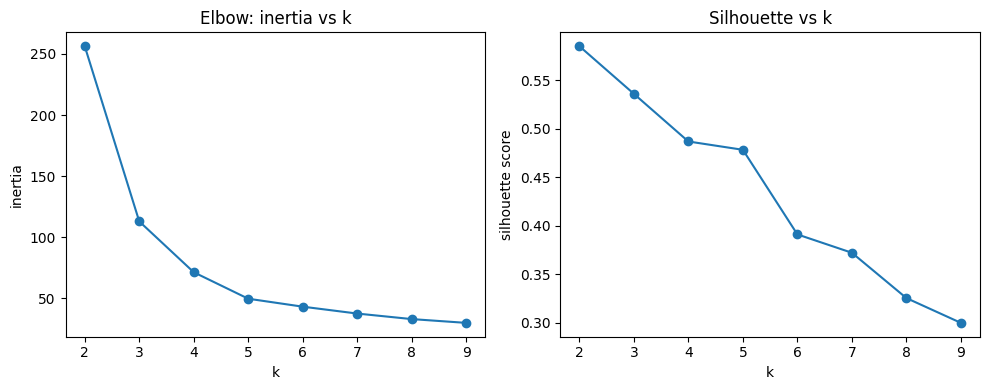

In [8]:
# Find best k via silhouette + elbow
sil_scores = {}
inertia = {}
Ks = range(2,10)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
    inertia[k] = km.inertia_

# Print results
print("k : silhouette")
for k in Ks:
    print(k, round(sil_scores[k],4))

# Plot elbow (inertia) and silhouette
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.title("Elbow: inertia vs k")
plt.xlabel("k")
plt.ylabel("inertia")

plt.subplot(1,2,2)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.tight_layout()
plt.show()


In [9]:
#Final KMeans 
k = 4
print("Selected k:", k)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
agg_filtered['cluster'] = kmeans.fit_predict(X_scaled)

# Show cluster sizes
print("Cluster sizes:")
print(agg_filtered['cluster'].value_counts().sort_index())

# Cluster centroids in original feature space (inverse transform)
centroids_scaled = kmeans.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_orig, columns=features)
centroids_df['cluster'] = range(k)
display(centroids_df)


Selected k: 4
Cluster sizes:
cluster
0    19
1    24
2    19
3    11
Name: count, dtype: int64


,avg_finish,std_finish,avg_start,win_rate,top5_rate,top10_rate,avg_laps_led,dnf_rate,avg_points,avg_stage_points,cluster
0,17.551177,10.076692,16.333712,1.534256e-02,0.117303,0.297110,4.015191,0.0,21.624593,2.716104,0
1,21.828622,8.801112,23.410749,3.058624e-03,0.030569,0.116552,0.768154,0.0,13.782221,0.626168,1
2,30.226135,5.785863,33.047765,3.469447e-18,0.000906,0.010209,0.049166,0.0,4.083578,0.005272,2
3,13.083746,10.727055,11.135663,7.516469e-02,0.324447,0.529595,20.399519,0.0,30.892260,6.743807,3


In [10]:
# Reorder clusters based on performance metrics
cluster_relabel = {3: 0, 0: 1, 1: 2, 2: 3}
agg_filtered["cluster"] = agg_filtered["cluster"].map(cluster_relabel)

# Add descriptive names
cluster_labels = {
    0: "Elite Contenders",
    1: "Consistent Mid-Pack",
    2: "Aggressive or Risky",
    3: "Developing/Backmarkers"
}
agg_filtered["cluster_name"] = agg_filtered["cluster"].map(cluster_labels)

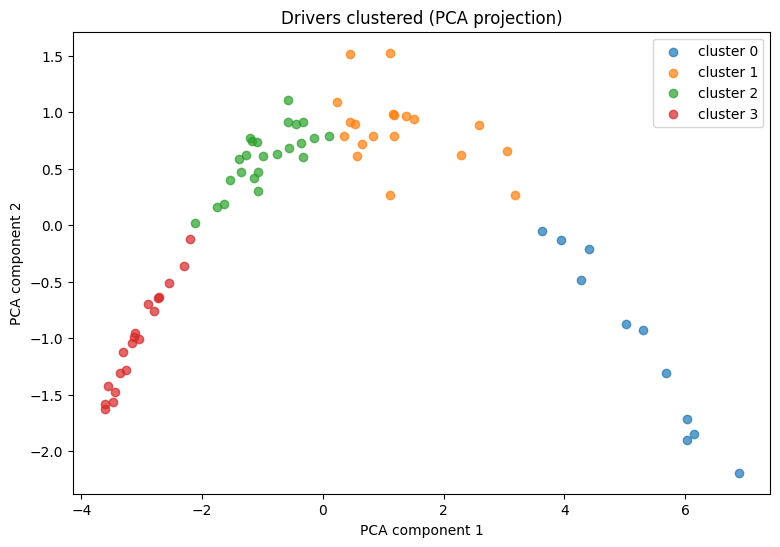

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


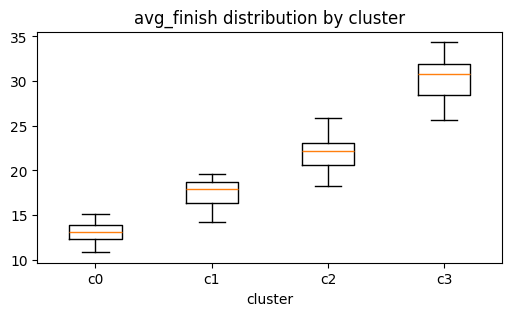

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


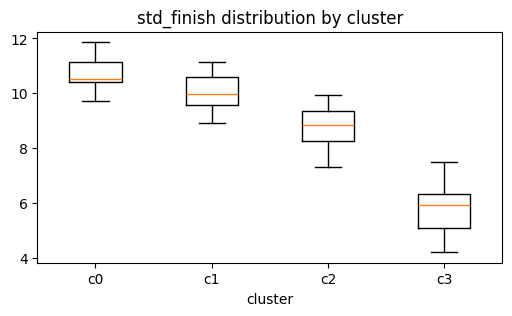

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


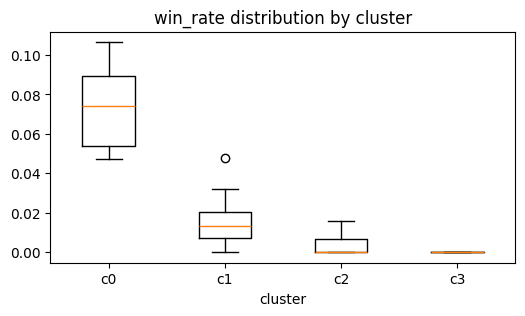

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


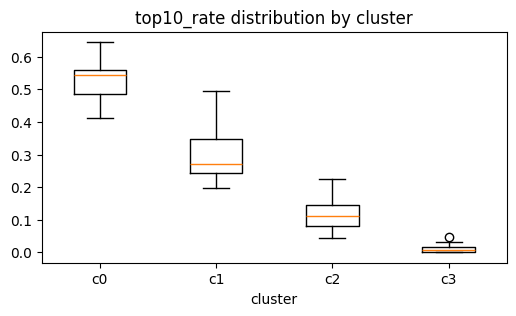

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


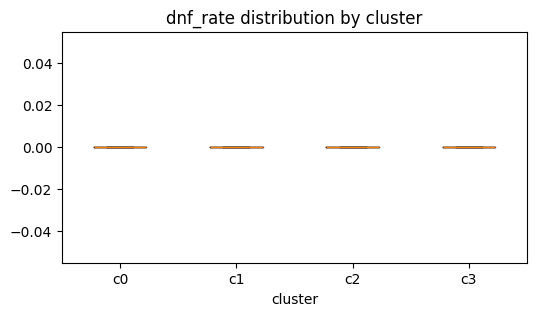

/var/folders/fk/qsrgb72x7297r48tth19dvy80000gp/T/ipykernel_47327/3318014582.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])


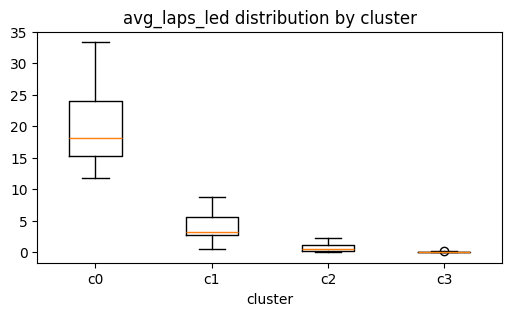

In [11]:
#PCA scatter plot
plt.figure(figsize=(9,6))
for c in sorted(agg_filtered['cluster'].unique()):
    sub = agg_filtered[agg_filtered['cluster'] == c]
    plt.scatter(sub['pca1'], sub['pca2'], label=f'cluster {c}', alpha=0.7)

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("Drivers clustered (PCA projection)")
plt.legend()
plt.show()

# Optional: boxplots of important features by cluster to interpret
for feat in ['avg_finish', 'std_finish', 'win_rate', 'top10_rate', 'dnf_rate', 'avg_laps_led']:
    plt.figure(figsize=(6,3))
    data_to_plot = [agg_filtered[agg_filtered['cluster'] == c][feat].dropna() for c in sorted(agg_filtered['cluster'].unique())]
    plt.boxplot(data_to_plot, labels=[f'c{c}' for c in sorted(agg_filtered['cluster'].unique())])
    plt.title(f"{feat} distribution by cluster")
    plt.xlabel("cluster")
    plt.show()


In [31]:
#List top representatives per cluster by wins or avg_finish
for c in sorted(agg_filtered['cluster'].unique()):
    print("\nCluster", c)
    display(agg_filtered[agg_filtered['cluster']==c].sort_values('win_rate', ascending=False)[['driver','total_races','avg_finish','win_rate','top10_rate','dnf_rate']].head(8))



Cluster 0


,driver,total_races,avg_finish,win_rate,top10_rate,dnf_rate
96,Kyle Larson,263,12.931559,0.106464,0.555133,0.0
91,Kevin Harvick,259,10.841699,0.100386,0.644788,0.0
102,"Martin Truex, Jr.",296,12.361486,0.091216,0.543919,0.0
51,Denny Hamlin,296,11.554054,0.087838,0.564189,0.0
95,Kyle Busch,296,13.131757,0.084459,0.560811,0.0
77,Joey Logano,296,13.081081,0.074324,0.537162,0.0
30,Chase Elliott,289,12.231834,0.072664,0.557093,0.0
17,Brad Keselowski,296,13.716216,0.054054,0.479730,0.0



Cluster 1


,driver,total_races,avg_finish,win_rate,top10_rate,dnf_rate
150,Tyler Reddick,188,15.622340,0.047872,0.430851,0.0
1,Alex Bowman,251,15.585657,0.031873,0.374502,0.0
94,Kurt Busch,206,14.179612,0.029126,0.495146,0.0
123,Ross Chastain,229,19.615721,0.021834,0.262009,0.0
31,Chris Buescher,295,17.447458,0.020339,0.254237,0.0
8,Austin Dillon,295,18.138983,0.020339,0.213559,0.0
73,Jimmie Johnson,161,17.925466,0.018634,0.285714,0.0
7,Austin Cindric,119,19.008403,0.016807,0.210084,0.0



Cluster 2


,driver,total_races,avg_finish,win_rate,top10_rate,dnf_rate
89,Kasey Kahne,63,20.587302,0.015873,0.111111,0.0
121,"Ricky Stenhouse, Jr.",296,19.962838,0.013514,0.158784,0.0
0,A.J. Allmendinger,151,19.907285,0.013245,0.225166,0.0
62,Harrison Burton,112,23.848214,0.008929,0.080357,0.0
37,Cole Custer,120,20.675000,0.008333,0.108333,0.0
108,Michael McDowell,296,20.881757,0.006757,0.145270,0.0
86,Justin Haley,148,22.222973,0.006757,0.114865,0.0
148,Ty Dillon,234,22.594017,0.000000,0.042735,0.0



Cluster 3


,driver,total_races,avg_finish,win_rate,top10_rate,dnf_rate
5,Anthony Alfredo,43,26.860465,0.0,0.046512,0.0
70,Jeffrey Earnhardt,54,31.777778,0.0,0.000000,0.0
119,Reed Sorenson,86,32.279070,0.0,0.000000,0.0
116,Quin Houff,91,31.725275,0.0,0.000000,0.0
113,Parker Kligerman,21,25.666667,0.0,0.000000,0.0
107,Matt Tifft,33,25.818182,0.0,0.030303,0.0
99,Landon Cassill,123,27.479675,0.0,0.008130,0.0
82,Josh Bilicki,102,31.392157,0.0,0.009804,0.0


In [21]:
agg_filtered.to_csv("path/driver_clusters_summary.csv", index=False)
print("Saved path/driver_clusters_summary.csv")

Saved /Users/martinjr./Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - AC02H70A0Q05H/School Documents/Kaggle Datasets/NASCAR/driver_clusters_summary.csv
